In [15]:
# Import the otb applications package
import otbApplication
import os
# Import lib for operating with multichannel image format
from libtiff import TIFF
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np


In [2]:
SIMPLE_FEATURES_TAGS = [
"Energy (texture uniformity)",
"Entropy (measure of randomness of intensity image)", 
"Correlation (how correlated a pixel is to its neighborhood)",
"Inverse Difference Moment (measures the texture homogeneity)",
"Inertia (intensity contrast between a pixel and its neighborhood)", 
"Cluster Shade", 
"Cluster Prominence", 
"Haralick Correlation"]

ADVANCED_FEATURES_TAGS = [
'Mean', 
'Variance (measures the texture heterogeneity)', 
'Dissimilarity',
'Sum Average', 
'Sum Variance', 
'Sum Entropy', 
'Difference of Entropies', 
'Difference of Variances', 
'IC', 
'IC2']

HIGHER_FEATURES_TAGS = [
'Short Run Emphasis (measures the texture sharpness)', 
'Long Run Emphasis (measures the texture roughness)', 
'Grey-Level Nonuniformity', 
'Run Length Nonuniformity', 
'Run Percentage (measures the texture sharpness homogeneity)',
'Low Grey-Level Run Emphasis', 
'High Grey-Level Run Emphasis', 
'Short Run Low Grey-Level Emphasis', 
'Short Run High Grey-Level Emphasis',
'Long Run Low Grey-Level Emphasis',
'Long Run High Grey-Level Emphasis']

def get_input_img(infile_name):
#     print(infile_name)
    extension = infile_name.split('.')[-1]
    if extension in ['tif', 'tiff']:
        img = TIFF.open(infile, mode='r').read_image()
    else:
        img = Image.open(infile_name)
    return img

        



def extract_haralic(infile_name,
                    outfile_name="HaralickTextures.tif",
                    channel=1,
                    xrad=3,
                    yrad=3,
                    xoff=1,
                    yoff=1,
                    nbbin = 10,
                    textures='simple', 
                   to_plot=False):
    
    ALLOWED_TEXUTRE_VALUES = ['simple', 'advanced', 'higher']
    
    img = get_input_img(infile_name)
    if to_plot:
        plt.figure(figsize=figure_size)
        plt.imshow(img)
        plt.show()
    
    if not textures in ALLOWED_TEXUTRE_VALUES:
        raise ValueError(f"'textures' must be in {allowed_texture_values}")
    # The following line creates an instance of the HaralickTextureExtraction application
    HaralickTextureExtraction = otbApplication.Registry.CreateApplication("HaralickTextureExtraction")
    
    HaralickTextureExtraction.SetParameterString("in", infile_name)
    
    HaralickTextureExtraction.SetParameterInt("channel", channel) # index of channel from which we process data (R-G-B, choose one to make gray)
    HaralickTextureExtraction.SetParameterInt("parameters.xrad", xrad)  # corresponds to size of 'texture probe'
    HaralickTextureExtraction.SetParameterInt("parameters.yrad", yrad)
    
    
    HaralickTextureExtraction.SetParameterInt("parameters.xoff", xoff)  # offset when calculating features (possible not for exact neigbours)
    HaralickTextureExtraction.SetParameterInt("parameters.yoff", yoff)
    
    
    HaralickTextureExtraction.SetParameterInt("parameters.min", 0)
    HaralickTextureExtraction.SetParameterInt("parameters.max", 512)
    
    HaralickTextureExtraction.SetParameterInt("parameters.nbbin", nbbin)

    HaralickTextureExtraction.SetParameterString("texture", textures)

    HaralickTextureExtraction.SetParameterString("out", os.path.join('output',outfile_name))
    # The following line execute the application
    HaralickTextureExtraction.ExecuteAndWriteOutput()
    return img

# UTILS 

In [3]:
FIGSIZE = (20,20)
def plot_haralic_features(infile="HaralickTextures.tif",
                         channels='all', 
                            textures_mode = "simple",
                         blend_channels=False, 
                         to_plot=False):
    
    print(to_plot)
    
    tif = TIFF.open(infile, mode='r')
    # read an image in the currect TIFF directory as a numpy array
    AVAILABLE_TEXTURE_MODS = ['simple', 'advanced', 'higher']
    AVAILABLE_TEXTURE_TAGS = {'simple' : SIMPLE_FEATURES_TAGS,
                              'advanced' : ADVANCED_FEATURES_TAGS,
                              'higher' : HIGHER_FEATURES_TAGS} 
    
    if not textures_mode in AVAILABLE_TEXTURE_MODS:
        raise ValueError(f"'textures_mode' should be one of {AVAILABLE_TEXTURE_MODS}, but found {texture_mode}")
    texture_tags = AVAILABLE_TEXTURE_TAGS[textures_mode]
    
    image = tif.read_image()
    if channels == 'all':
        indices = range(image.shape[2])
    else:
        indices = channels
        
    images = []
    if blend_channels:
        if not len(channels) in [1,3]:
            raise ValueError(f"'channels' when 'blend_channels' should have len 1 or 3, but found {len(channels)}")
        else:
            channel = image[:,:,channels]
            images.append(channel)
            if to_plot:
                plt.figure(figsize=FIGSIZE)
                plt.imshow(to_plot)
                plt.show()
    else:
        for indx in indices:
            images.append(image[:,:,indx])
            if to_plot:
                plt.imshow(image[:,:,indx])
                plt.title(texture_tags[indx])
                plt.show()
    return images


def plot_pair(im1, im2, title=''):
    fig = plt.figure(figsize=(10,10))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(im1)
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(im2)
    plt.title(title)
    plt.show()

In [4]:
textures_mode = 'simple'

TypeError: Failed to open file b'output/har_out_simple_3/bb6683a533_simple.tiff'

In [5]:
FIGSIZE = (10,10)
f_name = '1c41821d13.png'
nb = 100
rad = 3
infile = os.path.join('my_examples', f_name)
outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'
print(outfile_name)
textures_mode = 'simple'
raw_im = extract_haralic(infile_name=infile,
                outfile_name=outfile_name,
                    channel=1,
                    nbbin = nb,
                    xrad=rad,
                    yrad=rad,
                    textures=textures_mode)
resulting_im = plot_haralic_features(infile=os.path.join('output', outfile_name),
                    channels='all',
                    textures_mode = textures_mode,
                    blend_channels=False)
print(f'Homogenity mean [{np.mean(resulting_im[0], dtype=np.float16)}]')

1c41821d13_simple.tiff
False
Homogenity mean [0.1573486328125]


In [ ]:
# def features_to_df(x_filenames, y_filename):
    
#     image_features = []
#     for x_filename in x_filenames:
        
#         tif = TIFF.open(x_filename, mode='r').read_image()

#         image_features.extend([ 
#             tif[...,i].flatten()
#             for i in range(tif.shape[2])
#     #         for i in range(1)
#         ])
        
#      # TODO add features naming !!!
    
#     y = list(imageio.imread(y_filename).flatten()) 
    
#     y_max_val = np.max(y)
#     if y_max_val != 0:
#         y /= y_max_val
    
#     y = pd.DataFrame(y)
    
#     df = pd.DataFrame(image_features).T
#     df['y'] = y
#     return df

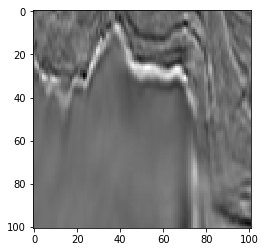

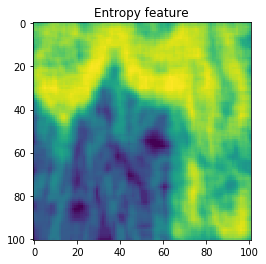

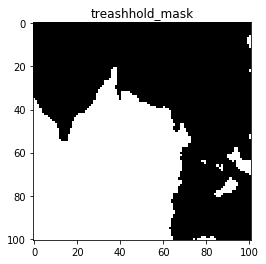

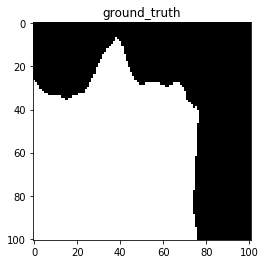

In [6]:
plt.imshow(raw_im)
plt.show()
normed = resulting_im[1] / np.max(resulting_im[1]) 
plt.imshow(normed)
plt.title('Entropy feature')
plt.show()
plt.imshow(
#     (resulting_im[0] + resulting_im[3] / np.max(resulting_im[3] ) ) /2 < 0.5 , cmap = 'gray')
 normed < 0.6, cmap = 'gray')
plt.title('treashhold_mask')
plt.show()
infile_name = os.path.join('my_examples', 'mask_1c41821d13.png')
ground_truth = get_input_img(infile_name)
plt.imshow(ground_truth , cmap = 'gray')
plt.title('ground_truth')
plt.show()

In [7]:
example_images = os.listdir('../data/train/images')


'83bb4578eb.png'

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


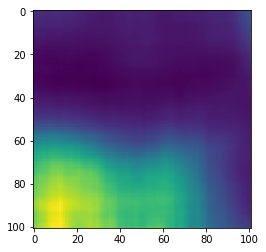

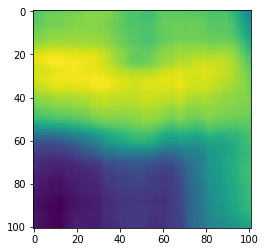

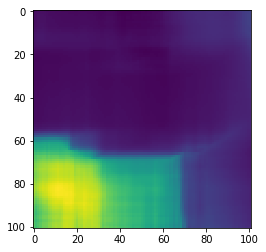

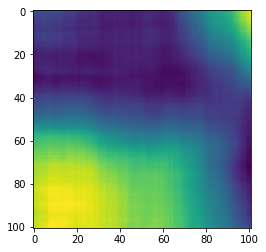

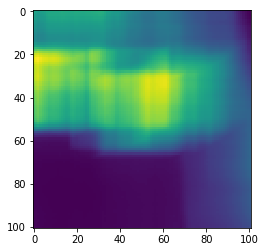

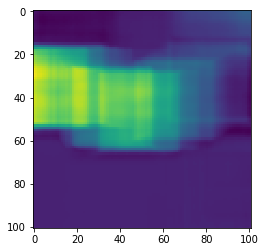

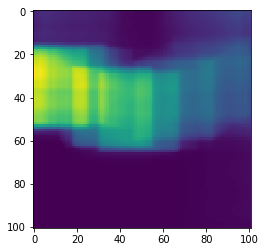

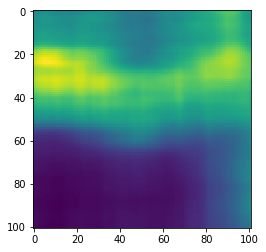

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


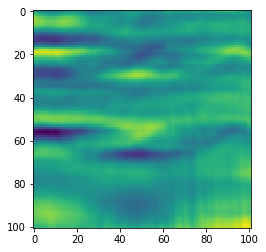

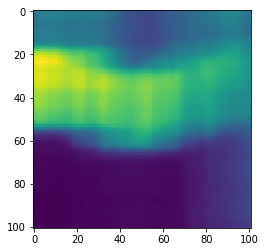

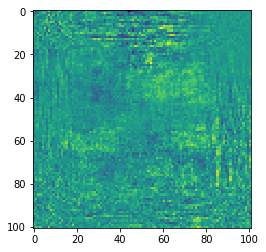

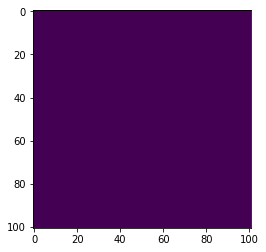

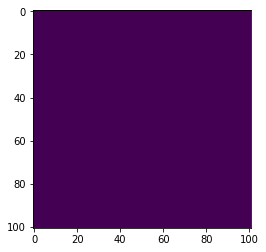

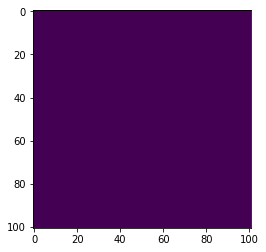

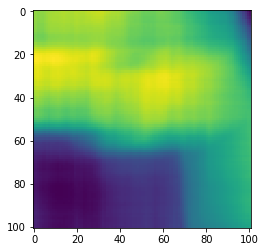

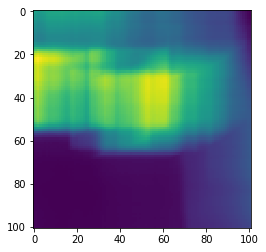

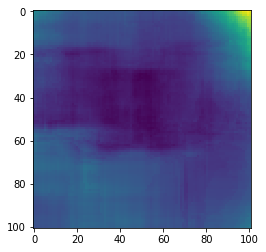

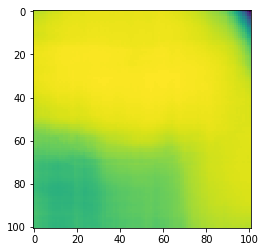

100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


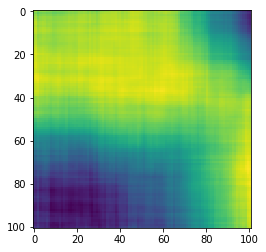

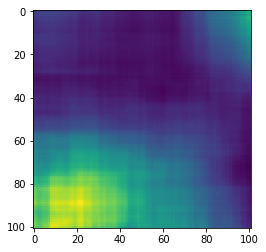

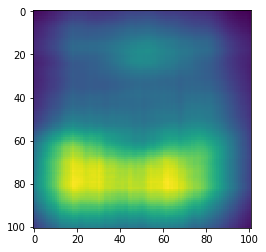

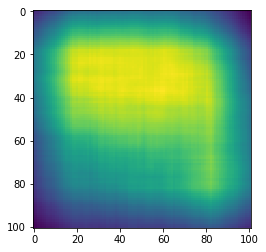

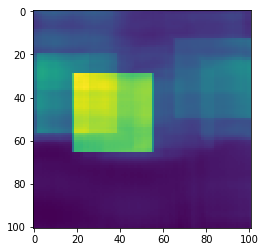

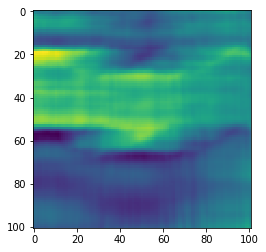

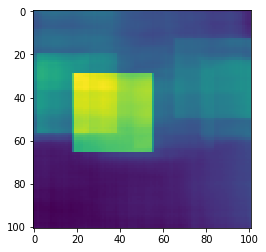

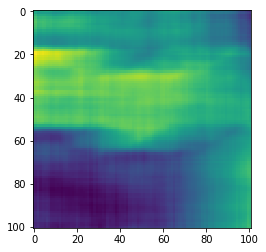

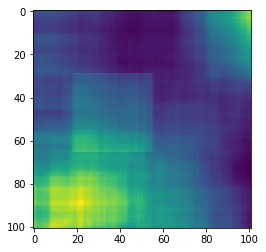

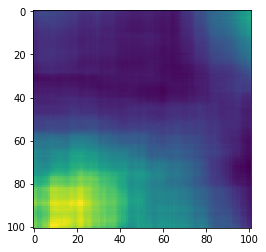

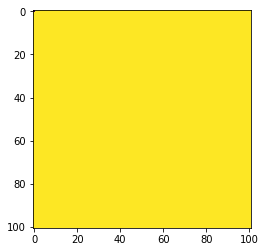

In [63]:
textures_modes = ['simple', 'advanced', 'higher']
for textures_mode in textures_modes:
    outdir = 'har_out_' + textures_mode + '_' + str(rad)
    rad = 18
    nb = 100
    if not os.path.exists(os.path.join('output', outdir) ):
        os.makedirs(os.path.join('output', outdir) )

    for f_name in tqdm( [example_images[23]] ):
        infile = os.path.join('../data/train/images', f_name)
        outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'


        outfile_name = os.path.join(outdir, outfile_name)

        raw_im = extract_haralic(infile_name=infile,
                outfile_name=outfile_name,
                    channel=1, #black&white images 
                    nbbin = nb,
                    xrad=rad,
                    yrad=rad,
                    textures=textures_mode)
        
    file_ids = [i.split('.')[0] for i in example_images]
    x_files = [os.path.join('output/har_out_' + textures_mode + '_' + str(rad) , f) + '_' + textures_mode + '.tiff' for f in file_ids]
    x_filename = x_files[23]
    tif = TIFF.open(x_filename, mode='r').read_image()
    for i in range(tif.shape[-1]):
        plt.imshow(tif[...,i])
        plt.show()

In [66]:
textures_modes = ['simple', 'advanced', 'higher']
for textures_mode in textures_modes:
    outdir = 'har_out_' + textures_mode + '_' + str(rad)
    rad = 9
    nb = 100
    if not os.path.exists(os.path.join('output', outdir) ):
        os.makedirs(os.path.join('output', outdir) )

    for f_name in tqdm( example_images ):
        infile = os.path.join('../data/train/images', f_name)
        outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'


        outfile_name = os.path.join(outdir, outfile_name)

        raw_im = extract_haralic(infile_name=infile,
                outfile_name=outfile_name,
                    channel=1, #black&white images 
                    nbbin = nb,
                    xrad=rad,
                    yrad=rad,
                    textures=textures_mode)

100%|██████████| 4000/4000 [54:00<00:00,  1.23it/s]


In [65]:
textures_modes = ['simple', 'advanced', 'higher']
for textures_mode in textures_modes:
    outdir = 'har_out_' + textures_mode + '_' + str(rad)
    rad = 18
    nb = 100
    if not os.path.exists(os.path.join('output', outdir) ):
        os.makedirs(os.path.join('output', outdir) )

    for f_name in tqdm( example_images ):
        infile = os.path.join('../data/train/images', f_name)
        outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'


        outfile_name = os.path.join(outdir, outfile_name)

        raw_im = extract_haralic(infile_name=infile,
                outfile_name=outfile_name,
                    channel=1, #black&white images 
                    nbbin = nb,
                    xrad=rad,
                    yrad=rad,
                    textures=textures_mode)

100%|██████████| 4000/4000 [1:42:17<00:00,  1.55s/it]


In [41]:
# infiles = os.listdir('output/har_out_simple')


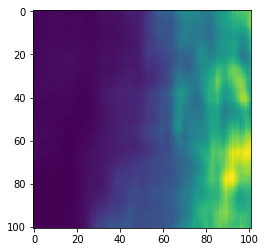

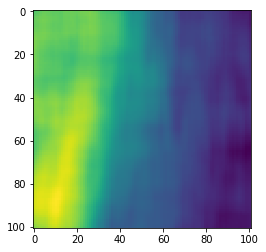

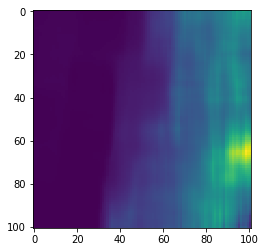

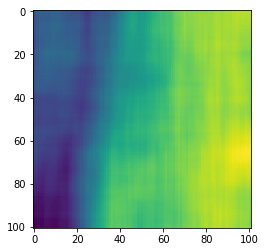

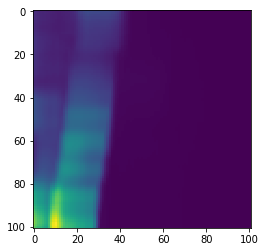

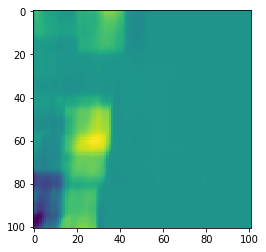

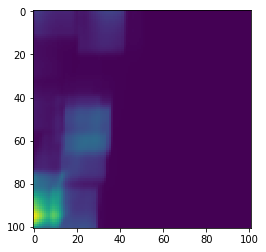

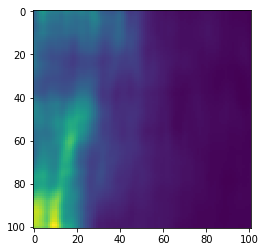

In [42]:
for i in range(tif.shape[-1]):
    plt.imshow(tif[...,i])
    plt.show()

In [11]:

from tqdm import tqdm as tqdm

In [9]:
FIGSIZE = (10,10)
nb = 100
rad = 3

In [12]:
textures_mode = 'simple'
outdir = 'har_out_' + textures_mode

if not os.path.exists(os.path.join('output', outdir) ):
    os.makedirs(os.path.join('output', outdir) )

for f_name in tqdm(example_images):
    infile = os.path.join('../data/train/images', f_name)
    outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'
    
    
    outfile_name = os.path.join(outdir, outfile_name)
    
    raw_im = extract_haralic(infile_name=infile,
            outfile_name=outfile_name,
                channel=1, #black&white images 
                nbbin = nb,
                xrad=rad,
                yrad=rad,
                textures=textures_mode)


100%|██████████| 4000/4000 [08:59<00:00,  7.87it/s]


In [13]:
textures_mode = 'advanced'
outdir = 'har_out_' + textures_mode

if not os.path.exists(os.path.join('output', outdir) ):
    os.makedirs(os.path.join('output', outdir) )

for f_name in tqdm(example_images):
    infile = os.path.join('../data/train/images', f_name)
    outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'
    
    
    outfile_name = os.path.join(outdir, outfile_name)
    
    raw_im = extract_haralic(infile_name=infile,
            outfile_name=outfile_name,
                channel=1, #black&white images 
                nbbin = nb,
                xrad=rad,
                yrad=rad,
                textures=textures_mode)


100%|██████████| 4000/4000 [17:11<00:00,  4.05it/s]


In [14]:
textures_mode = 'higher'
outdir = 'har_out_' + textures_mode

if not os.path.exists(os.path.join('output', outdir) ):
    os.makedirs(os.path.join('output', outdir) )

for f_name in tqdm(example_images):
    infile = os.path.join('../data/train/images', f_name)
    outfile_name = ''.join(infile.split('/')[-1].split('.')[:-1]) + '_' + textures_mode + '.tiff'
    
    
    outfile_name = os.path.join(outdir, outfile_name)
    
    raw_im = extract_haralic(infile_name=infile,
            outfile_name=outfile_name,
                channel=1, #black&white images 
                nbbin = nb,
                xrad=rad,
                yrad=rad,
                textures=textures_mode)


100%|██████████| 4000/4000 [36:09<00:00,  1.82it/s]


In [ ]:
# TODO get small subset of all features 200 images a.e.
# Train model on those example and evaluate best of them 

In [ ]:
outfile_name

In [ ]:
resulting_im = plot_haralic_features(infile=os.path.join('output', outfile_name),
                    channels='all',
                    textures_mode = textures_mode,
                    blend_channels=False)

In [ ]:
len(resulting_im)

In [ ]:
for i in range(8):
    plt.imshow(raw_im)
    plt.show()
    normed = resulting_im[i] / np.max(resulting_im[i]) 
    plt.imshow(normed)
    plt.title('Entropy feature')
    plt.show()
    plt.imshow(
    #     (resulting_im[0] + resulting_im[3] / np.max(resulting_im[3] ) ) /2 < 0.5 , cmap = 'gray')
     normed < 0.9, cmap = 'gray')
    plt.title('treashhold_mask')
    plt.show()
# infile_name = os.path.join('my_examples', 'mask_1c41821d13.png')
# ground_truth = get_input_img(infile_name)
# plt.imshow(ground_truth , cmap = 'gray')
# plt.title('ground_truth')
# plt.show()